In [1]:
import torch
from torch_geometric.loader import DataLoader
from data_creation import create_dataset, to_pyg_data_true
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import GAE
from torch.nn import BCEWithLogitsLoss
from torch_geometric.utils import negative_sampling
from torch.optim import Adam
import numpy as np

c:\Users\Lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# Generate just one huge graph
ode_dim = 100
n_data = 10
tp = torch.tensor(np.linspace(0,1,10))
x_exact, x_train, y_train, param = create_dataset(ode_dim,n_data,1,tp)

dataset_train = []
for i in range(0,len(x_train)):
    p = param[i]
    param_tensor = torch.cat((p.Win.flatten(),p.Wout.flatten(),p.bin.flatten(),p.bout.flatten(),p.gamma.flatten()))
    dataset_train.append(to_pyg_data_true(x_train[i],y_train[i],ode_dim,n_data*len(tp)))

data = dataset_train[0]

print(data.x.shape)

data = train_test_split_edges(data, val_ratio=0.1, test_ratio=0.1)

print(data)

torch.Size([100, 100])
Data(x=[100, 100], y=[10000], val_pos_edge_index=[2, 146], val_pos_edge_attr=[146], test_pos_edge_index=[2, 146], test_pos_edge_attr=[146], train_pos_edge_index=[2, 2352], train_pos_edge_attr=[2352], train_neg_adj_mask=[100, 100], val_neg_edge_index=[2, 146], test_neg_edge_index=[2, 146])


In [12]:
from torch_geometric.utils import dropout_edge
from torch.nn import Linear, Sequential, LeakyReLU

class GCNEncoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,hidden_channels=10):
        super(GCNEncoder, self).__init__()

        self.gcn1 = GCNConv(in_channels,hidden_channels)
        self.gcn2 = GCNConv(hidden_channels,out_channels)
        self.dropout_prob = 0.3

    def forward(self, x, edge_index):
        # edge_index, _ = dropout_edge(edge_index, p=self.dropout_prob, training=self.training)

        x = self.gcn1(x, edge_index=edge_index)
        x = torch.nn.functional.leaky_relu(x)
        x = self.gcn2(x,edge_index=edge_index)
        return x
    
class MLPDecoder(torch.nn.Module):
    def __init__(self, embedding_dim, hidden_dim=16):
        super(MLPDecoder, self).__init__()
        # Define the MLP for decoding
        self.mlp = Sequential(
            Linear(2 * embedding_dim, hidden_dim),
            LeakyReLU(),
            Linear(hidden_dim, 1)  # Output a single value (edge weight) for each pair
        )

    def forward(self, z, edge_index):
        # Extract source and target node embeddings based on edge_index
        src_nodes = z[edge_index[0]]  # Shape: (num_edges, embedding_dim)
        tgt_nodes = z[edge_index[1]]  # Shape: (num_edges, embedding_dim)

        # Concatenate source and target embeddings for each pair
        edge_features = torch.cat([src_nodes, tgt_nodes], dim=-1)  # Shape: (num_nodes, num_nodes, 2 * embedding_dim)

        # Pass through MLP to predict edge weights
        edge_weights = self.mlp(edge_features).squeeze(-1)  # Shape: (num_nodes, num_nodes)

        return edge_weights

In [13]:
model = GAE(GCNEncoder(n_data*len(tp),30),MLPDecoder(30))


optimizer = Adam(model.parameters(), lr=0.01)

criterion = BCEWithLogitsLoss()

reg = torch.nn.L1Loss()

train_loss = []

model.train()
for epoch in range(10000):
    optimizer.zero_grad()
    
    # Encode the node embeddings
    z = model.encode(data.x, data.train_pos_edge_index)
    
    # Positive edges (real edges)
    pos_edge_index = data.train_pos_edge_index
    
    # Negative edges (sampled non-existent edges)
    neg_edge_index = negative_sampling(
        edge_index=pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=pos_edge_index.size(1)
    )
    
    # Compute reconstruction logits for both positive and negative edges
    pos_logits = model.decoder(z, pos_edge_index)
    neg_logits = model.decoder(z, neg_edge_index)
    
    # Create labels for BCE loss (1 for positive edges, 0 for negative edges)
    pos_labels = torch.ones(pos_edge_index.size(1), device=z.device)
    neg_labels = torch.zeros(neg_edge_index.size(1), device=z.device)
    
    # Combine logits and labels
    logits = torch.cat([pos_logits, neg_logits], dim=0)
    labels = torch.cat([pos_labels, neg_labels], dim=0)
    
    # Compute BCE loss
    loss = criterion(logits, labels)

    #loss = loss + 0.001*reg(logits,0*logits)

    #loss = loss + 0.1*(1-reg(logits,0.5*torch.ones(len(logits))))
    #loss = loss + 0.1*(1-reg(logits,1*torch.ones(len(logits))))
    train_loss.append(loss.item())
    
    # Backpropagate and update weights
    loss.backward()
    optimizer.step()
    
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.6994072794914246
Epoch 2, Loss: 0.6952506899833679
Epoch 3, Loss: 0.69893479347229
Epoch 4, Loss: 0.6934663653373718
Epoch 5, Loss: 0.6941229104995728
Epoch 6, Loss: 0.6942354440689087
Epoch 7, Loss: 0.6941677927970886
Epoch 8, Loss: 0.6940306425094604
Epoch 9, Loss: 0.6938754916191101
Epoch 10, Loss: 0.6937265396118164
Epoch 11, Loss: 0.6935924291610718
Epoch 12, Loss: 0.6934803128242493
Epoch 13, Loss: 0.693414568901062
Epoch 14, Loss: 0.6933677196502686
Epoch 15, Loss: 0.6934123635292053
Epoch 16, Loss: 0.6934430599212646
Epoch 17, Loss: 0.6934550404548645
Epoch 18, Loss: 0.6933924555778503
Epoch 19, Loss: 0.6932982206344604
Epoch 20, Loss: 0.6932968497276306
Epoch 21, Loss: 0.6932644844055176
Epoch 22, Loss: 0.6932627558708191
Epoch 23, Loss: 0.6932218670845032
Epoch 24, Loss: 0.6931950449943542
Epoch 25, Loss: 0.6931729912757874
Epoch 26, Loss: 0.6930959820747375
Epoch 27, Loss: 0.6930535435676575
Epoch 28, Loss: 0.6930140852928162
Epoch 29, Loss: 0.69294053316116

KeyboardInterrupt: 

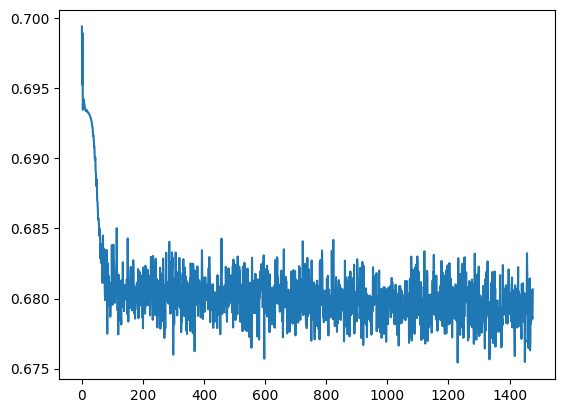

In [14]:
import matplotlib.pyplot as plt

tr_l = [train_loss[i] for i in range(0,len(train_loss))]
plt.plot(range(0,len(tr_l)),tr_l)
plt.show()

In [20]:
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.train_pos_edge_index)  # Encode with training edges
    
    # Validation
    val_pos_logits = model.decoder(z, data.val_pos_edge_index)
    val_neg_logits = model.decoder(z, data.val_neg_edge_index)
    val_labels = torch.cat([
        torch.ones(data.val_pos_edge_index.size(1), device=z.device),
        torch.zeros(data.val_neg_edge_index.size(1), device=z.device)
    ])
    val_logits = torch.cat([val_pos_logits, val_neg_logits], dim=0)
    val_loss = criterion(val_logits, val_labels)
    
    print("Validation Loss:", val_loss.item())
    
    # Test
    test_pos_logits = model.decoder(z, data.test_pos_edge_index)
    test_neg_logits = model.decoder(z, data.test_neg_edge_index)
    test_labels = torch.cat([
        torch.ones(data.test_pos_edge_index.size(1), device=z.device),
        torch.zeros(data.test_neg_edge_index.size(1), device=z.device)
    ])
    test_logits = torch.cat([test_pos_logits, test_neg_logits], dim=0)
    test_loss = criterion(test_logits, test_labels)
    
    print("Test Loss:", test_loss.item())

Validation Loss: 0.6880377531051636
tensor(0.4770)
tensor(0.4676)
Test Loss: 0.6993587017059326
